# Credit Card Fraud with Deep Learning

In [1]:
import pandas as pd 
import numpy as np
import imblearn
import haversine as hs # for caculating distance with lat & long
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns


%matplotlib inline

## Define Dataset:
---
This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants. You can find this dataset in [Source](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv).

## Data Dictionary

|   Name of Feature   |               Definition                       
|---------------------|---------------------------------------------|
| index               | Unique Identifier for each row              |
| cc_num              | Credit Card Number of Customer              |
| transdatetrans_time | Transaction DateTime                        |
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| zip                 | Zip of Credit Card Holder                   |
| first               | First Name of Credit Card Holder            |
| last                | Last Name of Credit Card Holder             |
| gender              | Gender of credit Card Holder                |
| street              | Street Address of Credit Card Holder        |
| lat                 | Latitude Location of Credit Card Holder     |               
| long                | Longitude Location of Credit Card Holder    |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| unix_time           | UNIX Time of transaction                    |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

In [2]:
# define the dataset location
train = pd.read_csv('dataset/fraudtrain.csv') 
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
test = pd.read_csv('dataset/fraudtest.csv') 
test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
print(train.shape)
print(test.shape)

(1296675, 23)
(555719, 23)


In [5]:
set(train.columns) - set(test.columns) # all the columns are same

set()

## Data Cleaning:

In [6]:
# drop unneseccery column for train dataset
train.drop(columns = "Unnamed: 0", inplace = True )
# check
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
# drop unneseccery column for test dataset
test.drop(columns = "Unnamed: 0", inplace = True )
# check
test.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


## Null Values:

In [8]:
train.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [9]:
# checking nulls in another way
columns_null_train = train.columns[train.isnull().any()]
#columns_null_train
print(len(columns_null_train))

0


In [10]:
test.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [11]:
#checking nulls in another way
columns_null_test = test.columns[test.isnull().any()]
#columns_null_test
print(len(columns_null_test))

0


In [12]:
# Finding different category, if exist
set(train['category']) - set(test['category'])

set()

In [13]:
train['category'].value_counts()

gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: category, dtype: int64

In [14]:
# seeing types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [16]:
# correct datatype
train['dob'] = pd.to_datetime(train['dob'])
test['dob'] = pd.to_datetime(test['dob'])

In [17]:
# creating different columns for year and month of birth
# train['year'] = train['dob'].dt.year
# test['year'] = test['dob'].dt.year

# train['month'] = train['dob'].dt.month
# test['month'] = test['dob'].dt.month

# train['year_month'] = train['dob'].dt.to_period('M')
# test['year_month'] = test['dob'].dt.to_period('M')

## Define Distance Based On Coordinates:
---
Euclidean Distance works for the flat surface like a Cartesian plain however, Earth is not flat. So we have to use a special type of formula known as Haversine Distance. You can find more in
[here](https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b).

In [18]:
# concatenating lat and long to create a consolidated location as accepted by havesine function
train['coor'] = list(zip(train.lat, train.long))
train['merch_coor'] = list(zip(train.merch_lat, train.merch_long))
test['coor'] = list(zip(test.lat, test.long))
test['merch_coor'] = list(zip(test.merch_lat, test.merch_long))

In [19]:
# Check
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,coor,merch_coor
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,"(36.0788, -81.1781)","(36.011293, -82.048315)"
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,"(48.8878, -118.2105)","(49.159047, -118.186462)"
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,"(42.1808, -112.262)","(43.150704, -112.154481)"
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,"(46.2306, -112.1138)","(47.034331, -112.561071)"
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,"(38.4207, -79.4629)","(38.674999, -78.632459)"


In [20]:
# defining a  function to calculate distance between two locations 
# loc1= location of a Merchant
# loc2= location of a Credit Card Holder
def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)

In [21]:
#from haversine import Unit
#To calculate distance in meters 
#hs.haversine(loc1,loc2,unit=Unit.METERS)

In [22]:
# Do the same thing for train data
distances = []
for i in range(train.shape[0]):
    distances.append(distance_from(train.iloc[i]['coor'], train.iloc[i]['merch_coor']))


In [23]:
# Define distance column
train['distances'] = distances

In [24]:
# Do the same thing for test data
distances = []
for i in range(test.shape[0]):
    distances.append(distance_from(test.iloc[i]['coor'], test.iloc[i]['merch_coor']))

In [25]:
# Define distance column
test['distances'] = distances

In [26]:
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,coor,merch_coor,distances
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,"(36.0788, -81.1781)","(36.011293, -82.048315)",78.60
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,"(48.8878, -118.2105)","(49.159047, -118.186462)",30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,"(42.1808, -112.262)","(43.150704, -112.154481)",108.21
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,"(46.2306, -112.1138)","(47.034331, -112.561071)",95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,"(38.4207, -79.4629)","(38.674999, -78.632459)",77.56


In [27]:
# One hot encoding
train = pd.get_dummies(train, columns=['category'], drop_first= True)
test = pd.get_dummies(test, columns=['category'], drop_first = True)
# entertainment does not exist

In [28]:
train = pd.get_dummies(train, columns=['gender'], drop_first= True)
test = pd.get_dummies(test, columns=['gender'], drop_first = True)
# 0 means Female and 1 means Male

In [29]:
# Correct datatype
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])

In [30]:
train['age'] = train['trans_date_trans_time'] - train['dob']
test['age'] = test['trans_date_trans_time'] - test['dob']
train['age'] = train['age']/ np.timedelta64(1, 'Y')
test['age'] = test['age']/ np.timedelta64(1, 'Y')

In [31]:
train.head()

,trans_date_trans_time,cc_num,merchant,amt,first,last,street,city,state,zip,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",4.97,Jennifer,Banks,561 Perry Cove,Moravian Falls,NC,28654,...,0,0,1,0,0,0,0,0,0,30.815144
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",107.23,Stephanie,Gill,43039 Riley Greens Suite 393,Orient,WA,99160,...,0,0,0,0,0,0,0,0,0,40.531977
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,220.11,Edward,Sanchez,594 White Dale Suite 530,Malad City,ID,83252,...,0,0,0,0,0,0,0,0,1,56.951205
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",45.00,Jeremy,White,9443 Cynthia Court Apt. 038,Boulder,MT,59632,...,0,0,0,0,0,0,0,0,1,51.970953
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,41.96,Tyler,Garcia,408 Bradley Rest,Doe Hill,VA,24433,...,0,0,0,1,0,0,0,0,1,32.764539


In [32]:
# To see if it has meaning to use or not
train['job'].value_counts()

Film/video editor             9779
Exhibition designer           9199
Naval architect               8684
Surveyor, land/geomatics      8680
Materials engineer            8270
                              ... 
Information officer              8
Veterinary surgeon               8
Ship broker                      7
Contracting civil engineer       7
Warehouse manager                7
Name: job, Length: 494, dtype: int64

In [33]:
train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 'first', 'last',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'coor', 'merch_coor', 'distances', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'age'],
      dtype='object')

In [34]:
train = train.drop(columns=['trans_date_trans_time','cc_num', 'merchant', 'first', 'last', 'trans_num', 'street', 'city', 'state', 'zip',
                           'job', 'lat', 'long', 'coor', 'merch_coor', 'unix_time', 'dob', 'merch_lat', 'merch_long'])


In [35]:
test = test.drop(columns=['trans_date_trans_time','cc_num', 'merchant', 'first', 'last', 'trans_num', 'street', 'city', 'state', 'zip',
                           'job', 'lat', 'long', 'coor', 'merch_coor', 'unix_time', 'dob', 'merch_lat', 'merch_long'])

In [36]:
train.head()

,amt,city_pop,is_fraud,distances,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age
0,4.97,3495,0,78.60,0,0,0,0,0,0,0,1,0,0,0,0,0,0,30.815144
1,107.23,149,0,30.21,0,0,0,1,0,0,0,0,0,0,0,0,0,0,40.531977
2,220.11,4154,0,108.21,0,0,0,0,0,0,0,0,0,0,0,0,0,1,56.951205
3,45.00,1939,0,95.67,0,1,0,0,0,0,0,0,0,0,0,0,0,1,51.970953
4,41.96,99,0,77.56,0,0,0,0,0,0,0,0,1,0,0,0,0,1,32.764539


In [37]:
test.head()

,amt,city_pop,is_fraud,distances,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age
0,2.86,333497,0,24.56,0,0,0,0,0,0,0,0,0,1,0,0,0,1,52.259827
1,29.84,302,0,104.93,0,0,0,0,0,0,0,0,0,1,0,0,0,0,30.427757
2,41.28,34496,0,59.08,0,0,0,0,1,0,0,0,0,0,0,0,0,0,49.669768
3,60.05,54767,0,27.70,0,0,0,0,0,0,0,0,1,0,0,0,0,1,32.911040
4,3.19,1126,0,104.34,0,0,0,0,0,0,0,0,0,0,0,0,1,1,64.963718


## Class Distribution:
Our target variable will be `is_fraud` which is a binary variable of whether the transaction was fraudulent. `0` corresponds to not fraudulent, while `1` corresponds to fraudent. Let's see how what proportion and number of transactions are fraudulant or not:

In [38]:
# summarize the class distribution
print(train.shape)
target = train['is_fraud']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(1296675, 19)
Class=0, Count=1289169, Percentage=99.421%
Class=1, Count=7506, Percentage=0.579%


There is a severe skew in the class distribution, with about 99.475 percent of transactions marked as normal and about 0.525 percent marked as fraudulent.

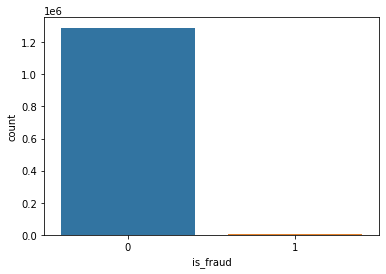

In [39]:
sns.countplot(x='is_fraud',data=train);

In [40]:
# ax = df.hist(bins=100)
# # disable axis labels to avoid the clutter
# for axis in ax.flatten():
#     axis.set_xticklabels([])
#     axis.set_yticklabels([])
# # show the plot
# pyplot.show()

## Define X, y:

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
# Check the corr between features and target
train_corr = train.corr()[['is_fraud']].sort_values('is_fraud', ascending=False)[1:]
train_corr

,is_fraud
amt,0.219404
category_shopping_net,0.044261
category_grocery_pos,0.035558
category_misc_net,0.025886
age,0.012271
gender_M,0.007642
category_shopping_pos,0.005955
city_pop,0.002136
distances,0.000403
category_gas_transport,-0.004851


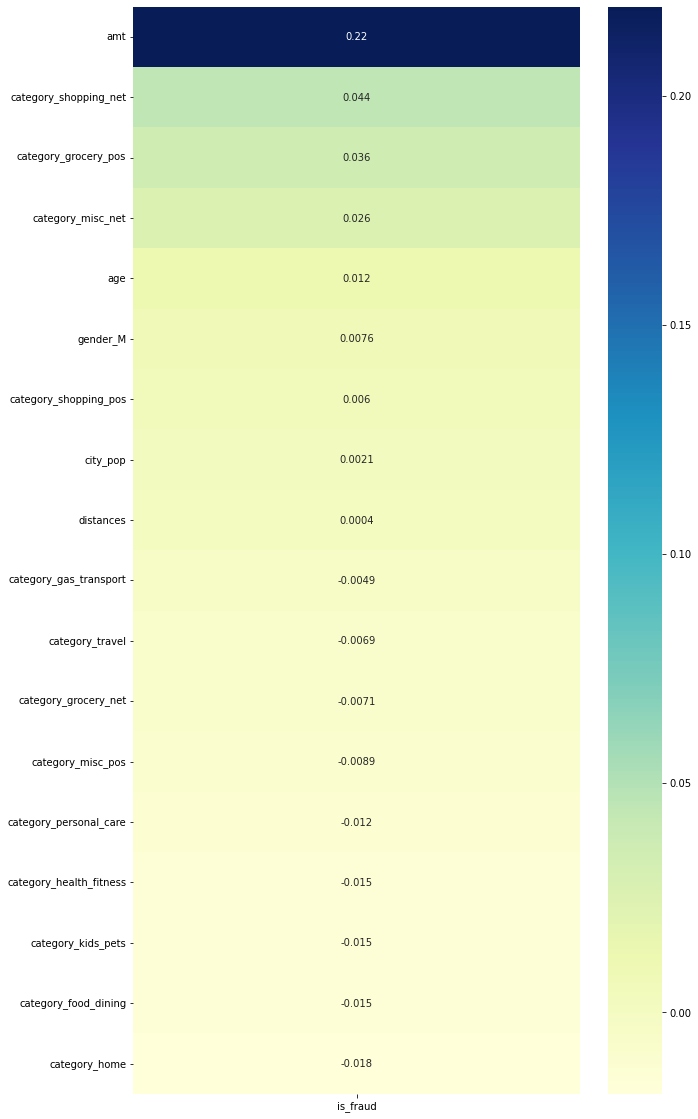

In [43]:
plt.figure(figsize=(10,20))
sns.heatmap(train_corr, annot=True, cmap="YlGnBu");

In [44]:
# Set up our X and y variables
# Need to handle the target being categorical
# Going to drop some string and time predictors variables.
X = train.drop(columns=['is_fraud', 'city_pop'])
#y = to_categorical(df.is_fraud)
y = train['is_fraud']

In [45]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [46]:
# summarize the class distribution
print(train.shape)
target = y
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(1296675, 19)
Class=0, Count=1289169, Percentage=50.000%
Class=1, Count=1289169, Percentage=50.000%


In [47]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent='myapplication')
# location = geolocator.geocode("Chicago IL")

In [48]:
# location.latitude

In [49]:
# location.latitude

### Train/Test Split
---

We always want to have a holdout set to test our model. Use the `train_test_split` function to split our `X` and `y` variables into a training set and a holdout set.

In [50]:
# Need to make sure train and test set both have fraudulent claims by using stratification.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify= y)

In [51]:
X_train.head()

,amt,distances,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age
1147973,18.610000,107.830000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,31.493062
1589141,1094.256871,75.817132,0,0,0,0,0,0,0,0,0,0,1,0,0,1,53.301317
886314,58.750000,111.200000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,43.744532
552122,11.450000,18.930000,0,0,0,0,0,1,0,0,0,0,0,0,0,1,24.023827
1379822,241.892511,13.932891,0,0,0,0,0,1,0,0,0,0,0,0,0,0,42.554470


### `StandardScaler`
---

Use an instance of `StandardScaler` to scale your `X_train` and `X_test` in the cell below.

In [52]:
ss =StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [53]:
import pickle

In [54]:
scalerfile = 'scaler.sav'
pickle.dump(ss, open(scalerfile, 'wb'))

Next we will build a network in Keras *on the entire dataset*. I start with a 4 layer network: the first 3 are dense layers with 100 nodes each with `relu` activation and the output layer is a dense layer with 2 nodes (classifcation for fraud) with `softmax` activation. 

## Instantiate our model:

In [55]:
# number of columns
n_cols=X.shape[1] 
# Instantiate model
model = Sequential()
# One by one, add Dense layers to our model.
# The hidden layers will use the ReLU activation
# Output layer will have softmax
model.add(Dense(64, activation='relu', input_shape = (n_cols,)))
model.add(Dense(32, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


2022-06-15 08:48:48.646019: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 08:48:48.646506: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [57]:
# We need to compile our model in Keras.
# Need to tell it three things:
# Optimizer (for us, usually Adam)
# Loss (which?)
# Metrics (Definitely need accuracy, but could do more)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [58]:
print(type(X_train_sc))
print(type(y_train))
print(type(X_test_sc))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [59]:
# Fit the model
history = model.fit(X_train_sc, y_train.values, batch_size =512, epochs=20, validation_data =(X_test_sc,y_test.values))

Train on 1933753 samples, validate on 644585 samples
Epoch 1/20
1933753/1933753 [==============================] - 28s 14us/sample - loss: 0.1589 - accuracy: 0.9374 - val_loss: 0.1075 - val_accuracy: 0.9567
Epoch 2/20
1933753/1933753 [==============================] - 27s 14us/sample - loss: 0.1022 - accuracy: 0.9588 - val_loss: 0.0985 - val_accuracy: 0.9600
Epoch 3/20
1933753/1933753 [==============================] - 26s 13us/sample - loss: 0.0957 - accuracy: 0.9615 - val_loss: 0.0919 - val_accuracy: 0.9617
Epoch 4/20
1933753/1933753 [==============================] - 25s 13us/sample - loss: 0.0908 - accuracy: 0.9640 - val_loss: 0.0880 - val_accuracy: 0.9633
Epoch 5/20
1933753/1933753 [==============================] - 26s 13us/sample - loss: 0.0877 - accuracy: 0.9656 - val_loss: 0.0882 - val_accuracy: 0.9670
Epoch 6/20
1933753/1933753 [==============================] - 26s 13us/sample - loss: 0.0853 - accuracy: 0.9666 - val_loss: 0.0838 - val_accuracy: 0.9682
Epoch 7/20
1933753/1933

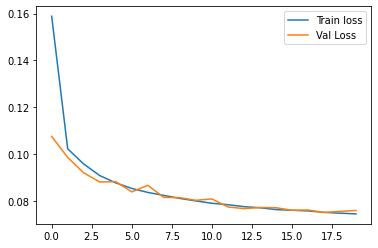

In [60]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

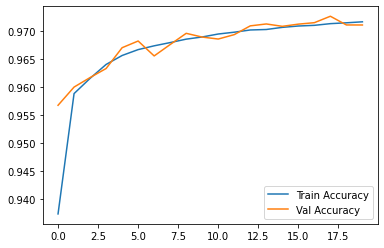

In [61]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend();

In [62]:
model.save("fraud_detection.h5")

In [63]:
# # Define function to create a neural network object
# def get_new_model():
#     model = Sequential()
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
#     #model.add(Dense(100, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     return(model)

Let's see how different learning rates affect our model performance. We'll also be sure to implement validation data (training/test) for training in the `model.fit()` method. I'm also going to implement *early stopping* and specify the number of training epochs to 3 for each learning rate for now.

In [64]:
# # Import the SGD optimizer
# #from keras.optimizers import SGD
# #from keras.callbacks import EarlyStopping


# # Create list of learning rates: lr_to_test
# lr_to_test = [0.000001, 0.01, 1]

# # Early stopping parameter
# es = EarlyStopping(monitor= 'val_accuracy', min_delta = 0, patience=3)

# # Loop over learning rates
# for lr in lr_to_test:
#     print('\n\nTesting model with learning rate: %f\n'%lr )
    
#     # Build new model to test, unaffected by previous models
#     model = get_new_model()
    
#     # Create SGD optimizer with specified learning rate: my_optimizer
#     my_optimizer = SGD(lr=lr)
    
#     # Compile the model
#     model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
#     # Fit the model
#     # epochs is 1 by default, we implement validation and early stopping
#     #model.fit(predictors,target, validation_split=0.4, epochs=5, callbacks = [early_stopping_monitor])
#     #model.fit(X_train_sc,y_train, validation_split=0.4, epochs=1)
#     history_es = model.fit(np.array(X_train_sc), np.array(y_train), batch_size =512, epochs=20, validation_data =(np.array(X_test_sc),np.array(y_test)), callbacks=[es])
    